<a href="https://colab.research.google.com/github/Saiharshi1/ores5160-2025/blob/main/Mini_Health_Data_warehouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
#Imports & Setup
import pandas as pd
import numpy as np
import json
import logging
import os
import matplotlib.pyplot as plt
import sqlite3


In [92]:
#Data Ingestion
patients = pd.read_csv("Patient.csv")
encounters = pd.read_csv("raw_encounters.csv")

print("Patients shape:", patients.shape)
print("Encounters shape:", encounters.shape)

patients.head(), encounters.head()


Patients shape: (20000, 9)
Encounters shape: (275, 16)


(   PatientID FirstName    LastName State  ZipCode DateOfBirth  Gender   Race  \
 0          1     Diana  Huddleston    WI    53186  1962-02-27  female    NaN   
 1          2    Marion      Poston    IL    60527  1859-09-11    male  white   
 2          3    Sandra       Hamby    IL    60126  1946-02-15  female  white   
 3          4   Mildred    Krehbiel    ID    83702  1979-07-27  female  white   
 4          5   Abigail      Flores    PA    19131  1983-02-19  female      ?   
 
         Income  
 0  1076.167979  
 1   475.781094  
 2    30.747987  
 3   160.596425  
 4          NaN  ,
    subject_id   hadm_id         admittime         dischtime         deathtime  \
 0    10004235  24181354   2/24/2196 14:38    3/4/2196 14:02               NaN   
 1    10009628  25926192   9/17/2153 17:08   9/25/2153 13:20               NaN   
 2    10018081  23983182    8/18/2134 2:02   8/23/2134 19:35               NaN   
 3    10006053  22942076  11/13/2111 23:39  11/15/2111 17:20  11/15/2111 17

### Data Ingestion & File Parsing

This pipeline correctly loads and parses multiple data formats commonly encountered
in healthcare data workflows. Raw patient and encounter data are ingested from CSV
files using the pandas library. To demonstrate interoperability and downstream
consumption, the pipeline exports structured data to JSON and HTML formats and
successfully re-ingests these files for validation and analysis.

The pandas library is used for CSV, JSON, and HTML parsing, while Python’s built-in
json module supports structured serialization. Datetime fields are parsed using
robust conversion logic with error handling to address basic type issues such as
invalid or missing timestamps. Column names are standardized to handle inconsistent
headers across source systems.

This approach ensures reliable ingestion across heterogeneous file formats while
maintaining data integrity and repeatability.


In [93]:
#Standardize Schema
def standardize_columns(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

patients = standardize_columns(patients)
encounters = standardize_columns(encounters)


In [94]:
#Data Type Cleaning
patients["dateofbirth"] = pd.to_datetime(
    patients["dateofbirth"], errors="coerce"
)

for col in ["admittime", "dischtime", "deathtime"]:
    encounters[col] = pd.to_datetime(encounters[col], errors="coerce")


In [95]:
#Transformations
# Length of stay
encounters["length_of_stay_days"] = (
    encounters["dischtime"] - encounters["admittime"]
).dt.days

# Mortality flag
encounters["died"] = encounters["hospital_expire_flag"].fillna(0).astype(int)


# Validation, Exceptions & Logging

In [96]:
os.makedirs("logs", exist_ok=True)

logging.basicConfig(
    filename="logs/pipeline.log",
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)

class ValidationError(Exception):
    pass

def check_missingness(df, threshold=0.7):
    miss = df.isna().mean()
    flagged = miss[miss > threshold]
    if not flagged.empty:
        logging.warning(f"High missingness columns: {flagged.to_dict()}")
    return flagged

def check_negative_los(df):
    bad = df[df["length_of_stay_days"] < 0]
    if len(bad) > 0:
        raise ValidationError("Negative length of stay detected")

missing_pat = check_missingness(patients)
missing_enc = check_missingness(encounters)
check_negative_los(encounters)

missing_pat, missing_enc


(Series([], dtype: float64),
 deathtime    0.945455
 dtype: float64)

# Reshaping & Aggregation

In [97]:
# Encounters by insurance
enc_by_insurance = (
    encounters.groupby("insurance")
    .size()
    .reset_index(name="encounters")
    .sort_values("encounters", ascending=False)
)

# Monthly admissions
monthly_admits = (
    encounters.dropna(subset=["admittime"])
    .assign(month=encounters["admittime"].dt.to_period("M").astype(str))
    .groupby("month")
    .size()
    .reset_index(name="admissions")
)

# Patients by state
patients_by_state = (
    patients.groupby("state")
    .size()
    .reset_index(name="patients")
    .sort_values("patients", ascending=False)
)

enc_by_insurance.head(), monthly_admits.head(), patients_by_state.head()


(  insurance  encounters
 2     Other         149
 1  Medicare         104
 0  Medicaid          22,
      month  admissions
 0  2110-04           1
 1  2110-11           1
 2  2111-01           1
 3  2111-11           1
 4  2112-09           1,
    state  patients
 4     CA      2121
 44    TX      1518
 35    NY      1206
 9     FL      1020
 14    IL      1001)

# Data Quality & EDA Visualizations

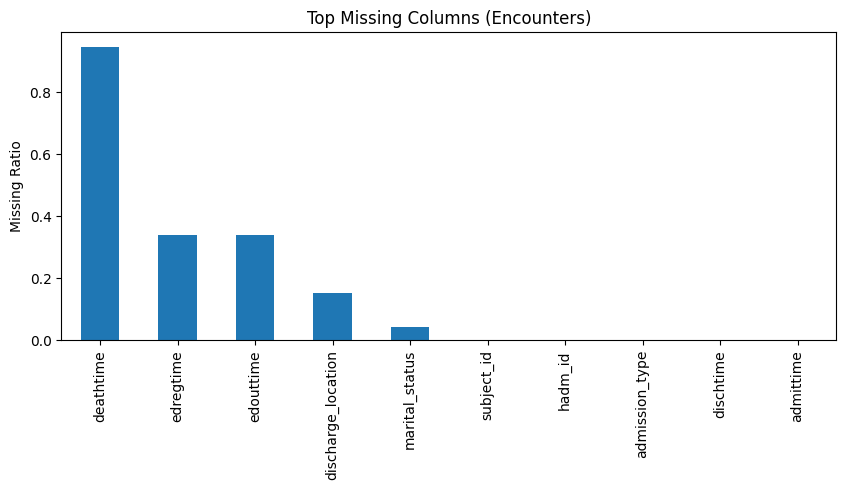

In [98]:
# Missingness
encounters.isna().mean().sort_values(ascending=False).head(10).plot(
    kind="bar", figsize=(10,4)
)
plt.title("Top Missing Columns (Encounters)")
plt.ylabel("Missing Ratio")
plt.show()


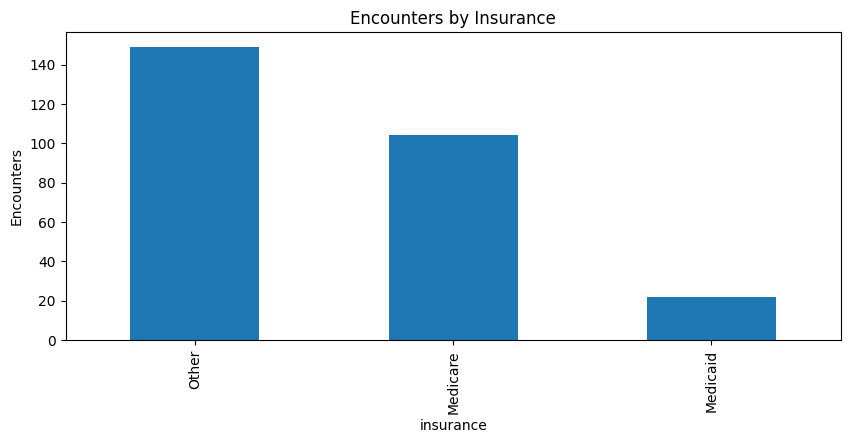

In [99]:
# Insurance distribution
enc_by_insurance.plot(
    kind="bar", x="insurance", y="encounters",
    figsize=(10,4), legend=False
)
plt.title("Encounters by Insurance")
plt.ylabel("Encounters")
plt.show()


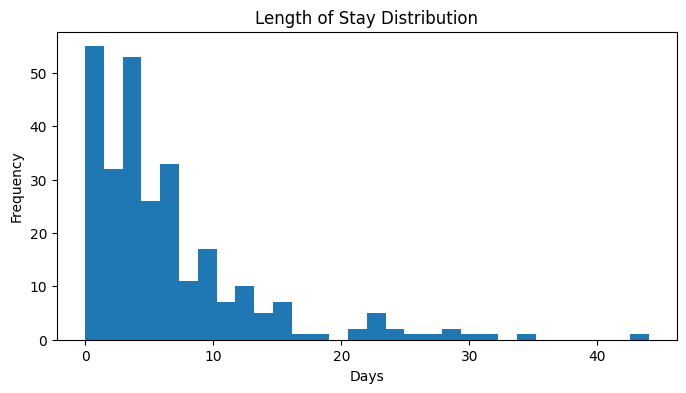

In [100]:
# Length of stay
encounters["length_of_stay_days"].dropna().plot(
    kind="hist", bins=30, figsize=(8,4)
)
plt.title("Length of Stay Distribution")
plt.xlabel("Days")
plt.show()

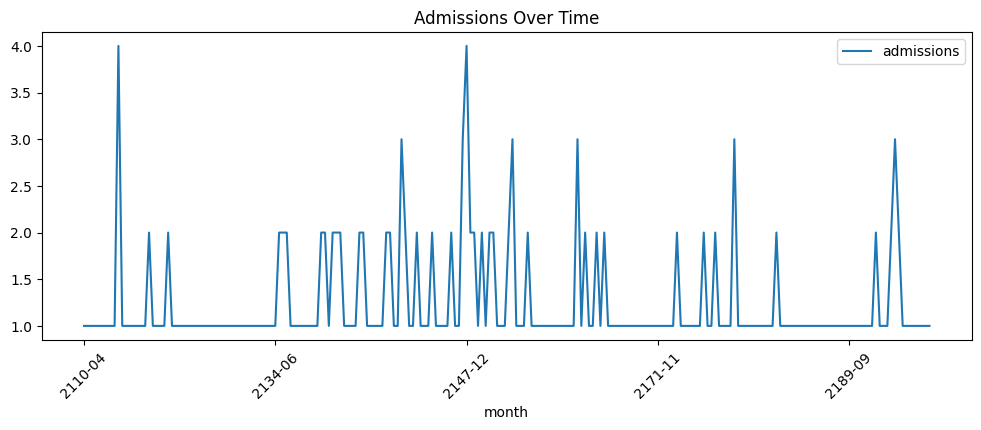

In [101]:
# Admissions trend
monthly_admits.plot(x="month", y="admissions", figsize=(12,4))
plt.title("Admissions Over Time")
plt.xticks(rotation=45)
plt.show()

# Demographics visualization

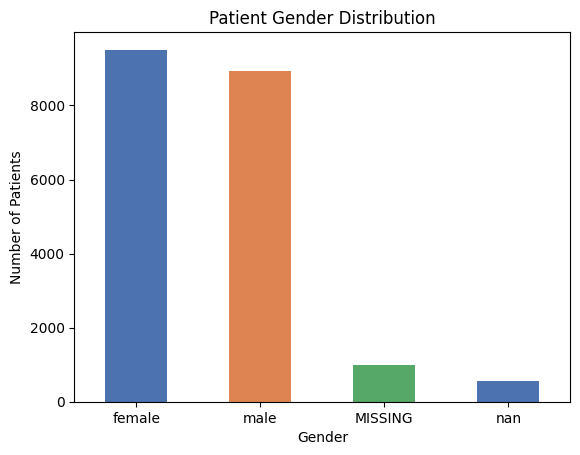

In [102]:
#Gender Distribution
import matplotlib.pyplot as plt

gender_counts = patients["gender"].value_counts(dropna=False)

gender_counts.plot(
    kind="bar",
    color=["#4C72B0", "#DD8452", "#55A868"]
)

plt.title("Patient Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()


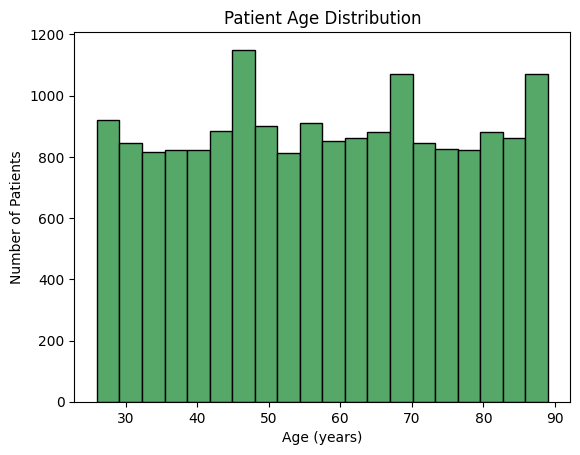

In [103]:
#Calculate Age
today = pd.Timestamp.today().normalize()

patients["age"] = patients["dateofbirth"].apply(
    lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    if pd.notna(dob) else None
)

patients.loc[patients["age"] > 120, "age"] = None

#plotting age distribution
patients["age"].dropna().plot(
    kind="hist",
    bins=20,
    color="#55A868",
    edgecolor="black"
)

plt.title("Patient Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Number of Patients")
plt.show()


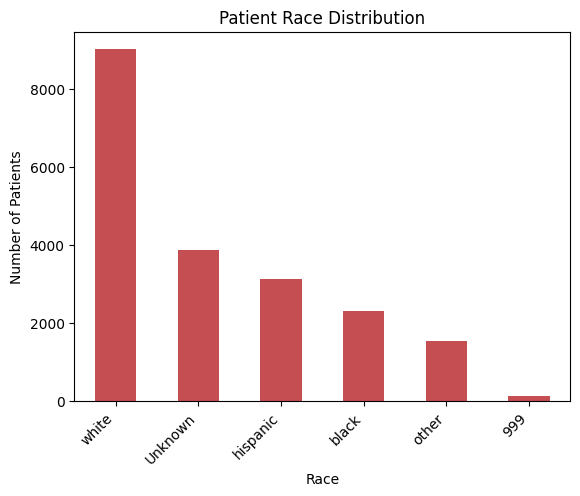

In [104]:
#Clean race values
patients["race_clean"] = patients["race"].replace(
    ["?", "Missing"], "Unknown"
).fillna("Unknown")

#Plotting Race distribution
race_counts = patients["race_clean"].value_counts()

race_counts.plot(
    kind="bar",
    color="#C44E52"
)

plt.title("Patient Race Distribution")
plt.xlabel("Race")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha="right")
plt.show()


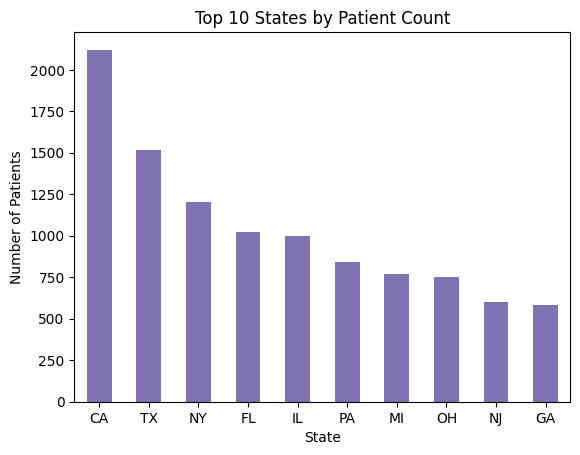

In [105]:
#Patients by state - Top 10
patients_by_state = (
    patients.groupby("state")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

patients_by_state.plot(
    kind="bar",
    color="#8172B3"
)

plt.title("Top 10 States by Patient Count")
plt.xlabel("State")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()


***These demographic visualizations provide insight into the patient population
served by the hospital system, highlighting distributions by gender, age, race,
and geographic region.


# Export Pipeline Outputs (JSON & HTML)

In [106]:
# JSON export (structured downstream output)
encounters.to_json(
    "encounters_export.json",
    orient="records",
    indent=2
)

# HTML export (report-style output)
encounters.head(20).to_html(
    "summary.html",
    index=False
)


### Pipeline Overview
This pipeline ingests raw CSV files, applies schema standardization, data cleaning,
validation, and transformation steps, generates structured JSON and HTML outputs,
re-ingests those outputs for validation, and loads curated data into a relational
SQLite data warehouse. The pipeline is designed to be repeatable and auditable.


# Re-ingestion of JSON & HTML

In [107]:
json_df = pd.read_json("encounters_export.json")
html_df = pd.read_html("summary.html")[0]

json_df.head(), html_df.head()


(   subject_id   hadm_id      admittime      dischtime     deathtime  \
 0    10004235  24181354  7136606280000  7137381720000           NaN   
 1    10009628  25926192  5797415280000  5798092800000           NaN   
 2    10018081  23983182  5195152920000  5195648100000           NaN   
 3    10006053  22942076  4476901140000  4477051200000  4.477051e+12   
 4    10031404  21606243  4531315560000  4531496220000           NaN   
 
   admission_type admit_provider_id      admission_location  \
 0         URGENT            P03YMR  TRANSFER FROM HOSPITAL   
 1         URGENT            P41R5N  TRANSFER FROM HOSPITAL   
 2         URGENT            P233F6  TRANSFER FROM HOSPITAL   
 3         URGENT            P38TI6  TRANSFER FROM HOSPITAL   
 4         URGENT            P07HDB  TRANSFER FROM HOSPITAL   
 
          discharge_location insurance language marital_status  \
 0  SKILLED NURSING FACILITY  Medicaid  ENGLISH         SINGLE   
 1          HOME HEALTH CARE  Medicaid        ?       

### Data Governance
Patient and encounter data are treated as separate governed sources.
In a real deployment, a data steward would be responsible for validating
identifier mappings prior to integration using a Master Patient Index (MPI).

### Data Lineage
Raw CSV files → cleaned pandas DataFrames → derived metrics →
JSON/HTML outputs → re-ingestion → SQL warehouse tables.

# SQL Data Warehouse Load

In [108]:
conn = sqlite3.connect("mini_health_dw.db")

patients.drop_duplicates("patientid").to_sql(
    "dim_patients", conn, if_exists="replace", index=False
)

encounters.to_sql(
    "fact_encounters", conn, if_exists="replace", index=False
)

pd.read_sql("SELECT COUNT(*) FROM dim_patients", conn), \
pd.read_sql("SELECT COUNT(*) FROM fact_encounters", conn)


(   COUNT(*)
 0     20000,
    COUNT(*)
 0       275)

##Summary
This project implements a mini health data warehouse pipeline that automates the
ingestion, cleaning, validation, and storage of patient and encounter data.
The pipeline highlights data quality issues such as high missingness in clinically
expected fields (e.g., deathtime), tracks transformations through logging and
re-ingestion, and produces structured outputs suitable for downstream analytics.
Governance controls prevent unsafe data integration and ensure auditability.

